**Note: This is very big notebook so it takes time to reload. Please read the complete notebook. Thanks.**

## Summary: 

    1. Introduction
    2. Retrieving the Data
    3. Glimpse of Data
    4. Extract pandas profile report for further analysis
    5. Descriptive Analysis
    6. Clean the data 
            6.1 Drop the featuers which has more than 15% null values 
            6.2 Drop the feature which has unique values
    7. Univariate Analysis
            7.1 Continious Features: Check outliers and distribution using Box Plot
            7.2 Continious Features: Check the normal distribution
            7.3 Categorical Features Frequency Count 
            7.4 T-Test : One Sample Location :T-Test
            7.5 Anova : One Way
    8. Bivariate Analysis
            8.1 T-Test : Two Sample Location T-Test
            8.2 Anova : Two way anova
            8.3 Chi2 Test
            8.4 Check variance
            8.5 Correlation
            8.6 Pair Plot  
            8.7 Removing Multicolinearity using VIF
    9.  Deal with outliers 
    10. Deal with missing values 
    11. Converting cateogrical columns to Numeric
    12. Feature Selection
    13. Standardize data
    14. Model Building
    15. Accuracy 


## Introduction 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [ ]:
!pip install researchpy

In [ ]:
import pandas as pd
pd.set_option('display.max_rows',None)

import numpy as np
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from sklearn.base import TransformerMixin
from scipy import stats
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")


## Retrieve the data 

In [ ]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv").reset_index(drop=True)
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv").reset_index(drop=True)

#### Since the data distribution is not same for the train and test dataset, we need to merge these datasets  and split it later. 

In [ ]:
df_train_temp  = df_train.copy()
df_test_temp  = df_test.copy()


df_train_temp['train_data']  = 1
df_test_temp['train_data']  = 0
df = pd.concat([df_train_temp, df_test_temp], axis=0,sort=False)

## Glimpse on the data

In [ ]:
df.head(10)

#### Pandas profiling : Report analysis:
You need to check below things:
    1. Cardinality
    2. Missing Values
    3. Skewnes & Kurtosis
    4. Unique Value
    5. Zeros
    6. Check Hormality (Normality) 
    7. Check correlation 
    8. Check IQR
    9. Check minimum and maximum value 
    10. Check Variance 


In [ ]:
# profile_report = ProfileReport(df, title='House Price - Pandas Report',explorative=True)
profile_report = ProfileReport(df, title='House Price - Pandas Report')


In [ ]:
# show pandas profil report
profile_report.to_notebook_iframe()

## Descriptive Analysis

In [ ]:
df.columns

In [ ]:
numerical_df = df[list(df._get_numeric_data().columns)].reset_index(drop=True)
categorical_df = df[list(set(df.columns) - set(df._get_numeric_data().columns))].reset_index(drop=True)

print ("Number of numeric columns = {}".format(len(numerical_df)))
print ("Number of categorical columns = {}".format(len(categorical_df)))

In [ ]:
# This function to extract the descriptive stats of numerical features
def extractSummmary(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Missing %'] = (df.isnull().sum()/df.isnull().count()*100).values
    summary['Uniques'] = df.nunique().values
    summary['Uniques %'] = (df.nunique().values/df.count()*100).values
    summary['Median'] = df.median().values
    summary['Mean'] = df.mean().values
    summary['Max'] = df.max().values
    summary['Min'] = df.min().values    
    summary['std'] = df.std().values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2) 
    return summary


# This function to extract the descriptive stats of categorical features
def extractSummmaryCategory(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing %'] = (df.isnull().sum()/df.isnull().count()*100).values

    summary['Uniques'] = df.nunique().values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2) 
    return summary



In [ ]:
summary =extractSummmary(numerical_df)
summary.sort_values('Uniques %',ascending=False)

In [ ]:

summary =extractSummmaryCategory(categorical_df)
summary.sort_values('Missing %',ascending=False).head(10)


In [ ]:
categorical_df.describe()

In [ ]:
categorical_df.mode()

## Clean the data

In [ ]:
# df.drop('Id',axis=1,inplace=True)
numerical_df.drop('Id',axis=1,inplace=True)

#### Drop the featuers which has more than 15% null values 

In [ ]:
# find out the features which has more than 40% null values
percent_categorical = (categorical_df.isnull().sum()/categorical_df.isnull().count()*100).sort_values(ascending=False)
print((percent_categorical[percent_categorical > 15]).index)

percent_numerical = (numerical_df.isnull().sum()/numerical_df.isnull().count()*100).sort_values(ascending=False)
print((percent_numerical[percent_numerical > 15]).index)


In [ ]:
# Drop the features
categorical_df = categorical_df.drop((percent_categorical[percent_categorical > 15]).index,1).reset_index(drop=True)
numerical_df = numerical_df.drop([key for key in (percent_numerical[percent_numerical > 15]).index if key != 'SalePrice'],1).reset_index(drop=True)


## Univariate Analysis

In [ ]:
target_feature = 'SalePrice'

def plot_boxplot(df, column, target_feature):
    sns.boxplot(x=column, y=target_feature, data = df)

def plot_dist(df,columns,f):
    ax1 = f.add_subplot(121)
    
    sns.distplot(df[columns],kde_kws={'bw': 0.1})
    ax2 = f.add_subplot(122)
    stats.probplot(df[columns], plot=ax2)

def plot_bar(df,column):
    sns.barplot(column,'SalePrice',data = df, alpha=0.9)
#     sns.barplot(df.index, df.values, alpha=0.9)

    


#### Continious Featuers : Box Plot:
*     This graph shows the shape of the distribution, its central value, and its variability.
    
*     Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).

In [ ]:

for i,column in enumerate(numerical_df.columns):
    f = plt.figure(figsize=(20,10))
    plot_boxplot(numerical_df, column,target_feature)


#### Continious Featuers : Data Distribution:
* The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential.
*  distplot lets you show a histogram with a line on it

In [ ]:

for i,column in enumerate(numerical_df.columns):
    f = plt.figure(figsize=(20,5))
    plot_dist(numerical_df, column,f)

#### Categorical : Frequency Count Plot :
* Frequency plots are a visual tool used to analyze numerical data by showing the pattern of how often different values occur

In [ ]:
for i,column in enumerate(numerical_df.columns):
    f = plt.figure(figsize=(20,5))
    plot_bar(numerical_df,column)

### T-test

A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features

<b> Null hypothesis (H0): u1 = u2, which translates to the mean of sample_01 is equal to the mean of sample 02 <br>
    Alternative hypothesis (H1): u1 ? u2, which translates to the means of sample01 is not equal to sample 02 </b>


#### One Sample Location :T-Test

* T-Test is most common and simple statistical test.
* Used to learn about averages across two categories.

* One- sample location : Compare average of certain category  with constant
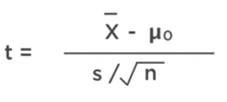

Lavene’s Test:

    Lavene’s test is used to test the variance of two or more category is same or not.
    Null Hypothesis: Population from which two samples are drawn have equal variance 
    If Levene’s test shows that null hypothesis nee	ds to be rejected 
    - Use two sample t-test for unequal  variances (Welch’s t-test)
    - Else you can use independent two sample  t-test for equal variance 



In [ ]:
def is_varaince_same(sample_01,sample_02,dependent_col):
    #     Ho: same variance
    #     H1: Varaicne are different

    
    print('\n\n\n-------------------------------------levene test for variance -------------------------\n')
    laven_test_result = stats.levene(sample_01[dependent_col], sample_02[dependent_col])
    print(laven_test_result)
    return laven_test_result.pvalue

def is_normally_dist(sample_01,sample_02,dependent_col):

    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(3,1,1)
    
    diff = scale(np.array(sample_01[dependent_col]) - np.array(sample_02[dependent_col], dtype=np.float))
    
    # Distribution  
    df_diff = pd.DataFrame(diff)
    ax = fig.add_subplot(3,1,1)
    df_diff.plot.hist()
    
    #     Shapiro wilk test for normality
    #     H0 : Normally distributed
    #     H1: 
    print('\n\n\n -------------------- shapiro test for normality ---------------------\n')
    print(stats.shapiro(diff))
    ax = fig.add_subplot(3,1,2)

    #     QQ plot 
    stats.probplot(diff, plot=ax, dist='norm')
    
    
def box_plot(df,independent_col,dependent_col):
    # Box plot 
    df.boxplot(column=[dependent_col], by=independent_col,figsize=(12,9))
    


def t_test(df, independent_col, dependent_col,sample_01,sample_02):
    #     fig = plt.figure()
    #     ax = fig.add_subplot(3,1,1)
    
           
    print('\n\n\n----------------------------------- Describe ----------------------------------\n')
    print(df.groupby(independent_col)[dependent_col].describe())
    
    box_plot(df,independent_col,dependent_col)

    #     Lavene's test 
    laven_test_result = is_varaince_same(sample_01,sample_02,dependent_col)
    if laven_test_result > 0.05:
        laven_variances = True
    else:
        laven_variances = False

    #     Check normality
    is_normally_dist(sample_01,sample_02,dependent_col)
    
    

    #     Independent t-test by using scipy.stats
    print('\n\n\n------------------------------ Independent T- Test ----------------------------------\n')
    print(stats.ttest_ind(sample_01[dependent_col], sample_02[dependent_col]))
    

    #     Independent t-test using researchpy
    variances =False
    print('\n\n\n-------------------------RP : T- Test ---------------------------------\n')
    descriptives, results = rp.ttest(sample_01[dependent_col], sample_02[dependent_col],equal_variances= laven_variances)
    print(descriptives)
    print('\n\n\n------------------------------------------------------------------------------\n')
    print(results)
    print('--------------------------------------------------------------------------------\n')

In [ ]:
percent_categorical = categorical_df[categorical_df.columns].nunique()
print((percent_categorical[percent_categorical == 2]).index)


In [ ]:
numerical_df.columns

In [ ]:
numerical_df['SalePrice'].values 

In [ ]:
categorical_df['SalePrice'] = numerical_df['SalePrice'].values 
for col in (percent_categorical[percent_categorical == 2]).index: 
    independent_col = col
    values = categorical_df[col].value_counts().index
    dependent_col ='SalePrice'
    sample_01 = categorical_df[(categorical_df[independent_col] == values[0])]
    sample_02 = categorical_df[(categorical_df[independent_col] == values[1])]
    if sample_01.shape[0] > sample_02.shape[0]:
        sample_val =  sample_02.shape[0]
        sample_01 = sample_01.sample(sample_val)
    else :
        sample_val =  sample_01.shape[0]
        sample_02 = sample_02.sample(sample_val)
        
        
    if sample_val > 3:
        t_test(categorical_df,col,dependent_col,sample_01,sample_02)
    else:
        print('Minimum 3 samples are required ')

## ANOVA

* T-test are useful to compare the differences between two groups/categories. T-test will tell you whether the averages across two groups or categories are different and if the difference are significant.
* Running multiple significance tests to compare across many groups is risky and leads to Type1 Error. Hence we need to use ANOVA.

ANOVA: 

* Looks for multiple groups of populations, compares their means to produce one score and one significance value.
* Perform a single ANOVA test to know whether the mean si different between these groups.
* Null Hypothesis: all groups are at an equal mean
* Alternate Hypothesis: all groups are NOT at an equal mean
* F-Stat:
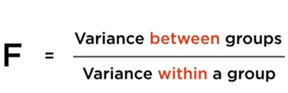

    If the groups are similar, F ~ 1 <br>
    If the groups are different, F will be large



### Anova Test : One Way

The one-way analysis of variance (ANOVA) is used to determine whether there are any statistically significant differences between the means of two or more independent (unrelated) groups (although you tend to only see it used when there are a minimum of three, rather than two groups).

<b> H0: No difference between means, i.e. ?x1 = ?x2 = ?x3 <br>
 Ha: Difference between means exist somewhere, i.e. ?x1 ? ?x2 ? ?x3, or ?x1 = ?x2 ? ?x3, or ?x1 ? ?x2 = ?x3

In [ ]:
# Extract the details to replace in below function

for col in (percent_categorical[percent_categorical > 2]).index:
    print("elif independent_col == '" + col +"' :")
    anova_cnd = []
    anova_cnd.append("one_way_anova= stats.f_oneway(")
    for feature in categorical_df[col].unique():
        anova_cnd.append("category_cols[dependent_col][category_cols[independent_col] == '" + str(feature)+"'],")
    
    anova_cnd.append(")")
    anova_str = ''.join(anova_cnd)
    print(anova_str)
    print('\n')

In [ ]:
def one_way_anova(category_cols,independent_col,dependent_col):
    print('\n -------------------- describe ---------------------\n')
    print(category_cols.groupby(independent_col)[dependent_col].describe().T)
    
    
    box_plot(category_cols,independent_col,dependent_col)
    
    print('\n\n -------------------- One way anova ---------------------\n')
     

    if independent_col == 'Functional' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Typ'],category_cols[dependent_col][category_cols[independent_col] == 'Min1'],category_cols[dependent_col][category_cols[independent_col] == 'Maj1'],category_cols[dependent_col][category_cols[independent_col] == 'Min2'],category_cols[dependent_col][category_cols[independent_col] == 'Mod'],category_cols[dependent_col][category_cols[independent_col] == 'Maj2'],category_cols[dependent_col][category_cols[independent_col] == 'Sev'],)
    
    elif independent_col == 'GarageCond' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'Po'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],)

    elif independent_col == 'HouseStyle' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == '2Story'],category_cols[dependent_col][category_cols[independent_col] == '1Story'],category_cols[dependent_col][category_cols[independent_col] == '1.5Fin'],category_cols[dependent_col][category_cols[independent_col] == '1.5Unf'],category_cols[dependent_col][category_cols[independent_col] == 'SFoyer'],category_cols[dependent_col][category_cols[independent_col] == 'SLvl'],category_cols[dependent_col][category_cols[independent_col] == '2.5Unf'],category_cols[dependent_col][category_cols[independent_col] == '2.5Fin'],)

    elif independent_col == 'PavedDrive' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Y'],category_cols[dependent_col][category_cols[independent_col] == 'N'],category_cols[dependent_col][category_cols[independent_col] == 'P'],)

    elif independent_col == 'BsmtQual' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],)

    elif independent_col == 'Condition2' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Norm'],category_cols[dependent_col][category_cols[independent_col] == 'Artery'],category_cols[dependent_col][category_cols[independent_col] == 'RRNn'],category_cols[dependent_col][category_cols[independent_col] == 'Feedr'],category_cols[dependent_col][category_cols[independent_col] == 'PosN'],category_cols[dependent_col][category_cols[independent_col] == 'PosA'],category_cols[dependent_col][category_cols[independent_col] == 'RRAn'],category_cols[dependent_col][category_cols[independent_col] == 'RRAe'],)

    elif independent_col == 'ExterCond' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],category_cols[dependent_col][category_cols[independent_col] == 'Po'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],)

    elif independent_col == 'BsmtExposure' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'No'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'Mn'],category_cols[dependent_col][category_cols[independent_col] == 'Av'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],)

    elif independent_col == 'KitchenQual' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],)

    elif independent_col == 'HeatingQC' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Ex'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],category_cols[dependent_col][category_cols[independent_col] == 'Po'],)

    elif independent_col == 'LotShape' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Reg'],category_cols[dependent_col][category_cols[independent_col] == 'IR1'],category_cols[dependent_col][category_cols[independent_col] == 'IR2'],category_cols[dependent_col][category_cols[independent_col] == 'IR3'],)

    elif independent_col == 'Exterior1st' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'VinylSd'],category_cols[dependent_col][category_cols[independent_col] == 'MetalSd'],category_cols[dependent_col][category_cols[independent_col] == 'Wd Sdng'],category_cols[dependent_col][category_cols[independent_col] == 'HdBoard'],category_cols[dependent_col][category_cols[independent_col] == 'BrkFace'],category_cols[dependent_col][category_cols[independent_col] == 'WdShing'],category_cols[dependent_col][category_cols[independent_col] == 'CemntBd'],category_cols[dependent_col][category_cols[independent_col] == 'Plywood'],category_cols[dependent_col][category_cols[independent_col] == 'AsbShng'],category_cols[dependent_col][category_cols[independent_col] == 'Stucco'],category_cols[dependent_col][category_cols[independent_col] == 'BrkComm'],category_cols[dependent_col][category_cols[independent_col] == 'AsphShn'],category_cols[dependent_col][category_cols[independent_col] == 'Stone'],category_cols[dependent_col][category_cols[independent_col] == 'ImStucc'],category_cols[dependent_col][category_cols[independent_col] == 'CBlock'],)

    elif independent_col == 'Exterior2nd' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'VinylSd'],category_cols[dependent_col][category_cols[independent_col] == 'MetalSd'],category_cols[dependent_col][category_cols[independent_col] == 'Wd Shng'],category_cols[dependent_col][category_cols[independent_col] == 'HdBoard'],category_cols[dependent_col][category_cols[independent_col] == 'Plywood'],category_cols[dependent_col][category_cols[independent_col] == 'Wd Sdng'],category_cols[dependent_col][category_cols[independent_col] == 'CmentBd'],category_cols[dependent_col][category_cols[independent_col] == 'BrkFace'],category_cols[dependent_col][category_cols[independent_col] == 'Stucco'],category_cols[dependent_col][category_cols[independent_col] == 'AsbShng'],category_cols[dependent_col][category_cols[independent_col] == 'Brk Cmn'],category_cols[dependent_col][category_cols[independent_col] == 'ImStucc'],category_cols[dependent_col][category_cols[independent_col] == 'AsphShn'],category_cols[dependent_col][category_cols[independent_col] == 'Stone'],category_cols[dependent_col][category_cols[independent_col] == 'Other'],category_cols[dependent_col][category_cols[independent_col] == 'CBlock'],)

    elif independent_col == 'BsmtFinType2' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Unf'],category_cols[dependent_col][category_cols[independent_col] == 'BLQ'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'ALQ'],category_cols[dependent_col][category_cols[independent_col] == 'Rec'],category_cols[dependent_col][category_cols[independent_col] == 'LwQ'],category_cols[dependent_col][category_cols[independent_col] == 'GLQ'],)

    elif independent_col == 'LotConfig' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Inside'],category_cols[dependent_col][category_cols[independent_col] == 'FR2'],category_cols[dependent_col][category_cols[independent_col] == 'Corner'],category_cols[dependent_col][category_cols[independent_col] == 'CulDSac'],category_cols[dependent_col][category_cols[independent_col] == 'FR3'],)

    elif independent_col == 'MasVnrType' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'BrkFace'],category_cols[dependent_col][category_cols[independent_col] == 'None'],category_cols[dependent_col][category_cols[independent_col] == 'Stone'],category_cols[dependent_col][category_cols[independent_col] == 'BrkCmn'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],)

    elif independent_col == 'GarageQual' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],category_cols[dependent_col][category_cols[independent_col] == 'Po'],)

    elif independent_col == 'RoofMatl' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'CompShg'],category_cols[dependent_col][category_cols[independent_col] == 'WdShngl'],category_cols[dependent_col][category_cols[independent_col] == 'Metal'],category_cols[dependent_col][category_cols[independent_col] == 'WdShake'],category_cols[dependent_col][category_cols[independent_col] == 'Membran'],category_cols[dependent_col][category_cols[independent_col] == 'Tar&Grv'],category_cols[dependent_col][category_cols[independent_col] == 'Roll'],category_cols[dependent_col][category_cols[independent_col] == 'ClyTile'],)

    elif independent_col == 'LandContour' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Lvl'],category_cols[dependent_col][category_cols[independent_col] == 'Bnk'],category_cols[dependent_col][category_cols[independent_col] == 'Low'],category_cols[dependent_col][category_cols[independent_col] == 'HLS'],)

    elif independent_col == 'Foundation' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'PConc'],category_cols[dependent_col][category_cols[independent_col] == 'CBlock'],category_cols[dependent_col][category_cols[independent_col] == 'BrkTil'],category_cols[dependent_col][category_cols[independent_col] == 'Wood'],category_cols[dependent_col][category_cols[independent_col] == 'Slab'],category_cols[dependent_col][category_cols[independent_col] == 'Stone'],)

    elif independent_col == 'Electrical' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'SBrkr'],category_cols[dependent_col][category_cols[independent_col] == 'FuseF'],category_cols[dependent_col][category_cols[independent_col] == 'FuseA'],category_cols[dependent_col][category_cols[independent_col] == 'FuseP'],category_cols[dependent_col][category_cols[independent_col] == 'Mix'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],)

    elif independent_col == 'MSZoning' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'RL'],category_cols[dependent_col][category_cols[independent_col] == 'RM'],category_cols[dependent_col][category_cols[independent_col] == 'C (all)'],category_cols[dependent_col][category_cols[independent_col] == 'FV'],category_cols[dependent_col][category_cols[independent_col] == 'RH'],)

    elif independent_col == 'BldgType' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == '1Fam'],category_cols[dependent_col][category_cols[independent_col] == '2fmCon'],category_cols[dependent_col][category_cols[independent_col] == 'Duplex'],category_cols[dependent_col][category_cols[independent_col] == 'TwnhsE'],category_cols[dependent_col][category_cols[independent_col] == 'Twnhs'],)

    elif independent_col == 'Neighborhood' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'CollgCr'],category_cols[dependent_col][category_cols[independent_col] == 'Veenker'],category_cols[dependent_col][category_cols[independent_col] == 'Crawfor'],category_cols[dependent_col][category_cols[independent_col] == 'NoRidge'],category_cols[dependent_col][category_cols[independent_col] == 'Mitchel'],category_cols[dependent_col][category_cols[independent_col] == 'Somerst'],category_cols[dependent_col][category_cols[independent_col] == 'NWAmes'],category_cols[dependent_col][category_cols[independent_col] == 'OldTown'],category_cols[dependent_col][category_cols[independent_col] == 'BrkSide'],category_cols[dependent_col][category_cols[independent_col] == 'Sawyer'],category_cols[dependent_col][category_cols[independent_col] == 'NridgHt'],category_cols[dependent_col][category_cols[independent_col] == 'NAmes'],category_cols[dependent_col][category_cols[independent_col] == 'SawyerW'],category_cols[dependent_col][category_cols[independent_col] == 'IDOTRR'],category_cols[dependent_col][category_cols[independent_col] == 'MeadowV'],category_cols[dependent_col][category_cols[independent_col] == 'Edwards'],category_cols[dependent_col][category_cols[independent_col] == 'Timber'],category_cols[dependent_col][category_cols[independent_col] == 'Gilbert'],category_cols[dependent_col][category_cols[independent_col] == 'StoneBr'],category_cols[dependent_col][category_cols[independent_col] == 'ClearCr'],category_cols[dependent_col][category_cols[independent_col] == 'NPkVill'],category_cols[dependent_col][category_cols[independent_col] == 'Blmngtn'],category_cols[dependent_col][category_cols[independent_col] == 'BrDale'],category_cols[dependent_col][category_cols[independent_col] == 'SWISU'],category_cols[dependent_col][category_cols[independent_col] == 'Blueste'],)

    elif independent_col == 'ExterQual' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Ex'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],)

    elif independent_col == 'RoofStyle' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Gable'],category_cols[dependent_col][category_cols[independent_col] == 'Hip'],category_cols[dependent_col][category_cols[independent_col] == 'Gambrel'],category_cols[dependent_col][category_cols[independent_col] == 'Mansard'],category_cols[dependent_col][category_cols[independent_col] == 'Flat'],category_cols[dependent_col][category_cols[independent_col] == 'Shed'],)

    elif independent_col == 'Heating' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'GasA'],category_cols[dependent_col][category_cols[independent_col] == 'GasW'],category_cols[dependent_col][category_cols[independent_col] == 'Grav'],category_cols[dependent_col][category_cols[independent_col] == 'Wall'],category_cols[dependent_col][category_cols[independent_col] == 'OthW'],category_cols[dependent_col][category_cols[independent_col] == 'Floor'],)

    elif independent_col == 'GarageType' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Attchd'],category_cols[dependent_col][category_cols[independent_col] == 'Detchd'],category_cols[dependent_col][category_cols[independent_col] == 'BuiltIn'],category_cols[dependent_col][category_cols[independent_col] == 'CarPort'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'Basment'],category_cols[dependent_col][category_cols[independent_col] == '2Types'],)

    elif independent_col == 'BsmtCond' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'TA'],category_cols[dependent_col][category_cols[independent_col] == 'Gd'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'Fa'],category_cols[dependent_col][category_cols[independent_col] == 'Po'],)

    elif independent_col == 'GarageFinish' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'RFn'],category_cols[dependent_col][category_cols[independent_col] == 'Unf'],category_cols[dependent_col][category_cols[independent_col] == 'Fin'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],)

    elif independent_col == 'SaleType' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'WD'],category_cols[dependent_col][category_cols[independent_col] == 'New'],category_cols[dependent_col][category_cols[independent_col] == 'COD'],category_cols[dependent_col][category_cols[independent_col] == 'ConLD'],category_cols[dependent_col][category_cols[independent_col] == 'ConLI'],category_cols[dependent_col][category_cols[independent_col] == 'CWD'],category_cols[dependent_col][category_cols[independent_col] == 'ConLw'],category_cols[dependent_col][category_cols[independent_col] == 'Con'],category_cols[dependent_col][category_cols[independent_col] == 'Oth'],)

    elif independent_col == 'BsmtFinType1' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'GLQ'],category_cols[dependent_col][category_cols[independent_col] == 'ALQ'],category_cols[dependent_col][category_cols[independent_col] == 'Unf'],category_cols[dependent_col][category_cols[independent_col] == 'Rec'],category_cols[dependent_col][category_cols[independent_col] == 'BLQ'],category_cols[dependent_col][category_cols[independent_col] == 'nan'],category_cols[dependent_col][category_cols[independent_col] == 'LwQ'],)

    elif independent_col == 'SaleCondition' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Normal'],category_cols[dependent_col][category_cols[independent_col] == 'Abnorml'],category_cols[dependent_col][category_cols[independent_col] == 'Partial'],category_cols[dependent_col][category_cols[independent_col] == 'AdjLand'],category_cols[dependent_col][category_cols[independent_col] == 'Alloca'],category_cols[dependent_col][category_cols[independent_col] == 'Family'],)

    elif independent_col == 'LandSlope' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Gtl'],category_cols[dependent_col][category_cols[independent_col] == 'Mod'],category_cols[dependent_col][category_cols[independent_col] == 'Sev'],)

    elif independent_col == 'Condition1' :
        one_way_anova= stats.f_oneway(category_cols[dependent_col][category_cols[independent_col] == 'Norm'],category_cols[dependent_col][category_cols[independent_col] == 'Feedr'],category_cols[dependent_col][category_cols[independent_col] == 'PosN'],category_cols[dependent_col][category_cols[independent_col] == 'Artery'],category_cols[dependent_col][category_cols[independent_col] == 'RRAe'],category_cols[dependent_col][category_cols[independent_col] == 'RRNn'],category_cols[dependent_col][category_cols[independent_col] == 'RRAn'],category_cols[dependent_col][category_cols[independent_col] == 'PosA'],category_cols[dependent_col][category_cols[independent_col] == 'RRNe'],)
    else:
        one_way_anova = 'no_feature'

    if one_way_anova == 'no_feature':
        pass
    else :
        print(one_way_anova)
    
        X = pd.get_dummies(category_cols[independent_col])
        y = category_cols[dependent_col]    
        print('\n\n\n --------------------  OLS  ---------------------\n')
        result = sm.OLS(y, X).fit()
        print(result.summary())

In [ ]:
categorical_df['SalePrice'] = numerical_df['SalePrice'].values 
for col in (percent_categorical[percent_categorical > 2]).index: 
    print('\n\n\n --------------------  '+ col +' ---------------------')
 
    independent_col = col
    values = categorical_df[col].value_counts().index
    dependent_col ='SalePrice'
    one_way_anova(categorical_df,col,dependent_col)


## Bivariate Analysis

### Anova Test : Two Way:

A two-way ANOVA test is a statistical test used to determine the effect of two nominal predictor variables on a continuous outcome variable.

#### I have tested for some but you can for other features

In [ ]:
from statsmodels.formula.api import ols
def two_way_Anova(df,independent_dependent_col):
    print(independent_dependent_col)
    model = ols(independent_dependent_col,df ).fit()
    print(model.summary())
    print('\n\n\n\n-------------------------------Two Way Anova -----------------------------------------\n')
    print(sm.stats.anova_lm(model))
    return model
    

In [ ]:
model = two_way_Anova(df, 'SalePrice ~ C(HouseStyle)+ C(Utilities)')

In [ ]:
model = two_way_Anova(df, 'SalePrice ~ C(SaleCondition)+ C(SaleType)')

### Chi2 Test

In [ ]:
# required imports
from scipy.stats import chi2_contingency

def caclucalte_Chi2(columns_0,columns_1):
    data_crosstab = pd.crosstab(chi2_df[columns_0], chi2_df[columns_1], margins = False) 
    stat, p, dof, expected = chi2_contingency(data_crosstab)
    alpha = 0.05
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print(f' Given variables [{columns_0},{columns_1}] are independent ')
    else:
        print(f'Given variables [{columns_0},{columns_1}] are dependent')
    return stat, p


In [ ]:
categorical_df.drop('SalePrice', axis=1, inplace=True)

In [ ]:

from sklearn import preprocessing
#  Insread of label encoder, we can create the dict and map it with column values 
def label_encoder(category_df):
    category_cols = category_df
    category_cols.dropna(inplace=True)
    lbl_df = pd.DataFrame()
    le = preprocessing.LabelEncoder()
    for column in category_cols.columns:
        lbl_df[column] = le.fit_transform(category_cols[column])
    return lbl_df

chi2_df = label_encoder(categorical_df.copy())
chi2_df.reset_index(drop=True,inplace=True)

In [ ]:
# data_crosstab = pd.crosstab(chi2_df['sex'], chi2_df['city'], margins = False) 

from itertools import permutations
for columns in list(permutations(chi2_df.columns, 2)):    
    caclucalte_Chi2(columns[0],columns[1])


### Check variance :
Check the variacne if it is very low then those features you can drop 

In [ ]:
abs(numerical_df.var())

In [ ]:
abs(numerical_df.corr()["SalePrice"][abs(numerical_df.corr()["SalePrice"])>0.5].drop('SalePrice')).index.tolist()

### Correlation

In [ ]:
#correlation matrix
f, ax = plt.subplots(figsize=(20, 18))
sns.heatmap( numerical_df.corr(), vmax=.8, annot=True,cmap='RdYlGn',annot_kws={'size':10});


### Removing Multicolinearity using VIF:

Check the multicolinearity and drop the features which are colinear with ither features 

In [ ]:
col_vif_dict = {}
numerical_df_temp = numerical_df.copy()
numerical_df_temp.dropna(inplace=True)
for cols in numerical_df_temp.columns:
    y = numerical_df_temp.loc[:, numerical_df_temp.columns == cols]
    x = numerical_df_temp.loc[:, numerical_df_temp.columns != cols]
    model = sm.OLS(y, x)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    col_vif_dict[cols] = vif

In [ ]:
col_vif_dict

In [ ]:
multicolinear_features = [key for key,value in col_vif_dict.items() if value > 30 and key not in ['SalePrice','train_data'] ]

In [ ]:
multicolinear_features

In [ ]:
# drop the columns 
numerical_df.drop(multicolinear_features, inplace=True, axis=1)


## Deal With Outliers:

In below function we are finding the outliers and set it to null so that we can impute it.  

In [ ]:
def out_iqr(df ):
    for column in df.columns:
        global lower,upper
        
        q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        # calculate the IQR
        iqr = q75 - q25
        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        # calculate the lower and upper bound value
        lower, upper = q25 - cut_off, q75 + cut_off
        
        # Calculate the number of records below and above lower and above bound value respectively
        df1 = df[df[column] > upper]
        df2 = df[df[column] < lower]
        if  df1.shape[0]+ df2.shape[0] > 0 and iqr > 0.0: 
            print('\n'+ column)
            print('The IQR is',iqr)
            print('The lower bound value is', lower)
            print('The upper bound value is', upper)
            print('Total number of outliers are', df1.shape[0]+ df2.shape[0])
            df.loc[(df[column] > upper) | (df[column] < lower),column] = np.nan

    return df   

In [ ]:
numerical_df = out_iqr(numerical_df)


## Impute Missing Data:

you can use multiple technique to impute missing value.
<br>
More details :
https://www.kaggle.com/questions-and-answers/174064

#### Numerical Features :Data correctness:


In [ ]:
# checking missing data
total = numerical_df.isnull().sum().sort_values(ascending = False)
percent = (numerical_df.isnull().sum()/numerical_df.isnull().count()*100).sort_values(ascending = False)
missing_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_data.head(21)

#### Categorical Features :Data correctness:


In [ ]:
# checking missing data
total = categorical_df.isnull().sum().sort_values(ascending = False)
percent = (categorical_df.isnull().sum()/categorical_df.isnull().count()*100).sort_values(ascending = False)
missing_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_data.head(21)


#### Check the missing percentage of missing data and drop those columns

In [ ]:
# List the column which has 20 % null value
def filterProblematicColumns(df,threshold):
    listOfColumnNames = []
    for col in df.columns.tolist():
        if df[col].isnull().sum()> threshold:
            listOfColumnNames.append(col)
            print(col)
    
    return listOfColumnNames

# Set threshold for categorical features
portion = 0.20
threshold = categorical_df.shape[0] * portion
columnsToDrop = filterProblematicColumns(categorical_df, threshold)

# categorical_features = categorical_features.drop(columns=columnsToDrop)

# Set threshold for categorical features
portion = 0.20
threshold = numerical_df.shape[0] * portion
columnsToDrop = filterProblematicColumns(numerical_df, threshold)
# numerical_features = numerical_features.drop(columns=columnsToDrop)


Create function to set mean value to numerical features and mode value to categorical features

In [ ]:
class MissingImputer(TransformerMixin):
    def __init__(self):
        pass
#         Categorical features : most frequent value : Mode() 
#         Continious features : average value : mean() 

    def fit(self, X, y=None):

        self.fill = pd.Series(
            [
                X[c].value_counts().index[0]
                if X[c].dtype == np.dtype("O")
                else X[c].mean()
                for c in X
            ],
            index=X.columns,
        )

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

impute mode value to categorical features 

In [ ]:
categorical_df = MissingImputer().fit_transform(categorical_df)


impute mean value to numerical features 

In [ ]:
numerical_df = MissingImputer().fit_transform(numerical_df)


In [ ]:
summary =extractSummmary(numerical_df)
summary.head(20)


In [ ]:
summary =extractSummmaryCategory(categorical_df)
summary.head(20)

## Converting cateogrical columns to Numeric


In [ ]:
def one_hot_encoding(df,all_columns,prefixs=None):
    df_one_hot = pd.get_dummies(df, 
                         columns=all_columns, 
                         prefix= prefixs, 
                         drop_first=True)
    return df_one_hot

def frequency_encoding(df, columns):
    for column in columns: 
        fe = df.groupby(column).size()/len(df)
        df[column]=df[column].map(fe)
    return df 

In [ ]:
summary = pd.DataFrame(index = categorical_df.columns)
summary['Unique'] = categorical_df[categorical_df.columns].nunique().values
summary.head(100)

In [ ]:
categorical_df = one_hot_encoding(categorical_df,categorical_df.columns)


In [ ]:
numerical_df.reset_index(drop=True, inplace=True)
categorical_df.reset_index(drop=True, inplace=True)

In [ ]:
all_df = pd.concat([numerical_df,categorical_df],axis=1)
# df.loc[df['column_name'] == some_value]

final_df = all_df.loc [all_df['train_data'] == 1]
final_df_test = all_df.loc [all_df['train_data'] == 0]




In [ ]:
final_df_test.count()

In [ ]:
final_df_test.drop('SalePrice', axis=1,inplace=True)

In [ ]:

target_col = 'SalePrice'
X = final_df.loc[:, final_df.columns != target_col]
y = final_df.loc[:, target_col]
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                    test_size=0.33, 
                                                    random_state=42)

### Standardize data

In [ ]:
# Normalizing the Data
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

### Model Building

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import math
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [ ]:
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

In [ ]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)

In [ ]:
from sklearn import metrics
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

In [ ]:
xgb.fit(X,y)
lgbm.fit(X, y,eval_metric='rmse')

In [ ]:
predict4 = lgbm.predict(final_df_test)
predict3 = xgb.predict(final_df_test)
predict_y = ( predict3*0.45 + predict4 * 0.55)



In [ ]:
submission = pd.DataFrame({
        "Id": df_test["Id"],
        "SalePrice": predict_y
    })
submission.to_csv('../working/submission.csv', index=False)

In [ ]:
print('Done')